<a href="https://colab.research.google.com/github/Saroramath/MachineLearning/blob/main/6205A/6205A6Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist


# Prepare the dataset

> Step 1: Load the data

In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


> Step 2: Normalize the images

In [3]:
def normalize_img(image, label):
  return tf.cast(image, tf.float32) / 255., label

In [4]:
ds_train = ds_train.map(normalize_img)
ds_test = ds_test.map(normalize_img)

> Step 3: Convert to dataframes

In [5]:
df_train = tfds.as_dataframe(ds_train, ds_info)
df_test = tfds.as_dataframe(ds_test,ds_info)

In [6]:
df_train.info()

<class 'tensorflow_datasets.core.as_dataframe.StyledDataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   60000 non-null  object
 1   label   60000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 937.6+ KB


In [7]:
df_test.info()

<class 'tensorflow_datasets.core.as_dataframe.StyledDataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   10000 non-null  object
 1   label   10000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 156.4+ KB


> Step 4: Combine train and test dataframes to increase the dataset

In [8]:
df = df_train.append(df_test)

In [9]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 70000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   70000 non-null  object
 1   label   70000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.6+ MB


> Step 5: Create the synthetic data

In [10]:
df0=df.loc[lambda df: df['label'] == 0, :]

In [11]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6903 entries, 2 to 9998
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   6903 non-null   object
 1   label   6903 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 161.8+ KB


In [12]:
df6 = df.loc[lambda df: df['label'] == 6, :]

In [13]:
df6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6876 entries, 9 to 9983
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   6876 non-null   object
 1   label   6876 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 161.2+ KB


In [14]:
df6 = df6[:500]

In [15]:
df6.image[9].shape

(28, 28, 1)

In [16]:
df6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 9 to 4763
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   500 non-null    object
 1   label   500 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 31.7+ KB


In [17]:
df_new = df0.append(df6)

In [18]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7403 entries, 2 to 4763
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   7403 non-null   object
 1   label   7403 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 173.5+ KB


## Split the data in taining and test data

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
dftrain, dftest = train_test_split(df_new, test_size=0.20, random_state=42)

In [98]:
num_anomo = dftest.label[dftest.label==6].count()
print(num_anomo)

102


> There are 102 anomolies in the test data.

We will only train with the 0 label so we should choose that from the new training data so we do not use anything separarted out for testing.

In [22]:
df_0train = dftrain.loc[lambda dftrain: dftrain['label'] == 0, :]

In [23]:
df_0train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5524 entries, 2127 to 8517
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   5524 non-null   object
 1   label   5524 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 129.5+ KB


In [24]:
#x_train = np.array(df_0train['image'])    Not givig an array of right size 
#y_train = np.array(df_0train['label'])# all values 0

In [25]:
data = []
for x in df_0train.image:
  data.append(x)
x_train = np.array(data).reshape(-1,28,28)


In [26]:
x_train.shape

(5524, 28, 28)

In [27]:
data = []
for x in df_0train.label:
  data.append(x)
y_train = np.array(data) 

In [28]:
y_train.shape

(5524,)

In [29]:
data = []
for x in dftest.image:
  data.append(x)
x_test = np.array(data).reshape(-1,28,28)

In [30]:
x_test.shape

(1481, 28, 28)

In [31]:
data = []
for x in dftest.label:
  data.append(x)
y_test = np.array(data)  

In [32]:
y_test.shape

(1481,)

# Model

In [33]:
encoder = tf.keras.models.Sequential([
          tf.keras.layers.InputLayer(input_shape=(28,28))  ,                          
         tf.keras.layers.Flatten(),
         tf.keras.layers.Dense(100, activation = 'selu', kernel_initializer= 'lecun_normal'),
         tf.keras.layers.Dense(30, activation = 'selu', kernel_initializer= 'lecun_normal'),])
decoder = tf.keras.models.Sequential([
          tf.keras.layers.Dense(100, activation = 'selu', input_shape= [30]),
          tf.keras.layers.Dense(28*28, activation= 'sigmoid'),
          tf.keras.layers.Reshape([28,28])])

autoencoder = tf.keras.models.Sequential([encoder, decoder])
autoencoder.compile(loss = 'mse', optimizer = 'adam')




In [34]:
encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 30)                3030      
Total params: 81,530
Trainable params: 81,530
Non-trainable params: 0
_________________________________________________________________


In [35]:
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 100)               3100      
_________________________________________________________________
dense_3 (Dense)              (None, 784)               79184     
_________________________________________________________________
reshape (Reshape)            (None, 28, 28)            0         
Total params: 82,284
Trainable params: 82,284
Non-trainable params: 0
_________________________________________________________________


In [36]:
history= autoencoder.fit(x_train,x_train,epochs=20)

Epoch 1/20
173/173 [==============================] - 1s 4ms/step - loss: 0.0857
Epoch 2/20
173/173 [==============================] - 1s 4ms/step - loss: 0.0292
Epoch 3/20
173/173 [==============================] - 1s 4ms/step - loss: 0.0203
Epoch 4/20
173/173 [==============================] - 1s 4ms/step - loss: 0.0165
Epoch 5/20
173/173 [==============================] - 1s 4ms/step - loss: 0.0143
Epoch 6/20
173/173 [==============================] - 1s 4ms/step - loss: 0.0130
Epoch 7/20
173/173 [==============================] - 1s 4ms/step - loss: 0.0121
Epoch 8/20
173/173 [==============================] - 1s 4ms/step - loss: 0.0112
Epoch 9/20
173/173 [==============================] - 1s 4ms/step - loss: 0.0107
Epoch 10/20
173/173 [==============================] - 1s 4ms/step - loss: 0.0103
Epoch 11/20
173/173 [==============================] - 1s 4ms/step - loss: 0.0100
Epoch 12/20
173/173 [==============================] - 1s 4ms/step - loss: 0.0095
Epoch 13/20
173/173 [====

In [38]:
decoded_imgs=autoencoder.predict(x_train)

## Visualize the reconstruction

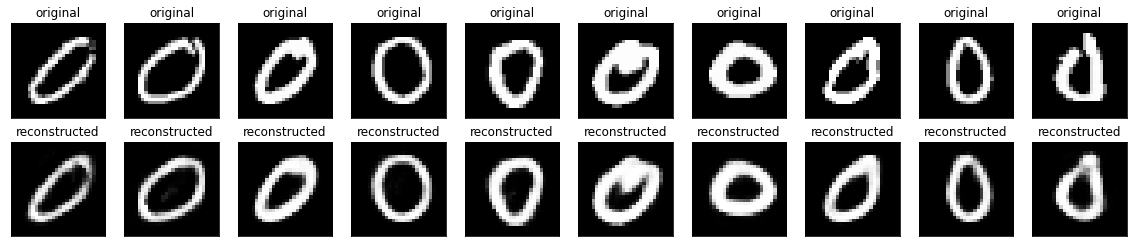

In [39]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_train[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

## Absolute error in reconstruction

In [40]:
abs = np.abs(decoded_imgs - x_train)
abs = abs.reshape(-1, 28*28)


In [41]:
abs.shape

(5524, 784)

In [42]:
loss = np.mean(abs, axis=1)

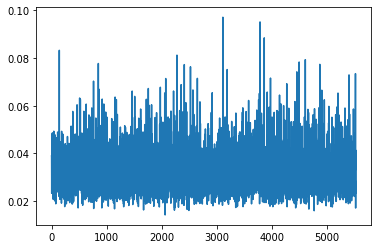

In [43]:
plt.plot(loss)

> We observe that there is a lot of loss among the regular images set itself. So it will be difficult to seperate anomoloies.

In [44]:
max_loss = loss.max()

In [45]:
max_loss

0.097085856

In [47]:
max_loss_index = np.where(loss == max_loss)

> Visulatze image with maximum error

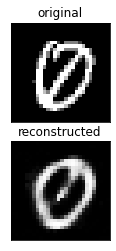

In [48]:
n = 1
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_train[max_loss_index].reshape(28,28))
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[max_loss_index].reshape(28,28))
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

In [49]:
mean_loss = loss.mean()

In [50]:
variance_loss = loss.var()

## Assign threshold

> We will assign the threshhold as the largest reconstruction error excluding 0.01% worst reconstructed regular images.

In [52]:
t = 0.01*5524
print(t)

55.24


In [ ]:
mean_loss + variance_loss

0.03253915

In [53]:
ind_max = np.argpartition(loss, -55)[-55:]

In [54]:
ind_max

array([ 463, 1815,  629,  949, 2693, 1153, 1509, 4416, 1176, 3576, 4869,
       4479, 3772, 3971,  510,  523, 4160,  919, 3758, 4137, 1720, 2437,
       4950, 5198, 4605, 4451, 3109, 4904, 2521, 3914, 2352,  857,  849,
       5398, 4868, 2276, 2566, 3860, 2646, 1463, 3187,  762, 1974, 4493,
       2214, 3973, 5515, 4268, 3783, 2916, 1756,  141, 2072, 2054, 2409])

In [62]:
threshold = loss[ind_max[0]]

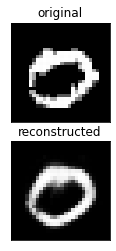

In [58]:
n = 1
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_train[ind_max[0]].reshape(28,28))
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[ind_max[0]].reshape(28,28))
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

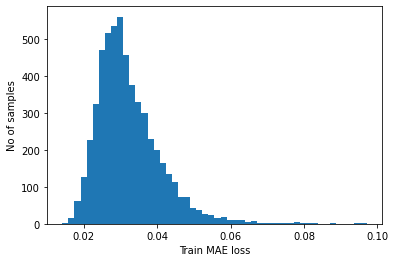

In [59]:
plt.hist(loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Prediction 

In [60]:
decoded_test = autoencoder.predict(x_test)

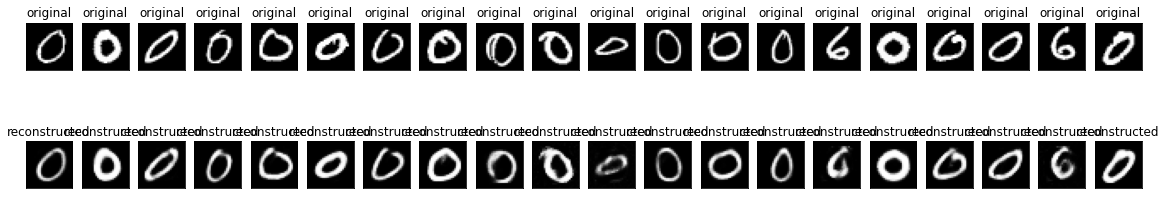

In [61]:
n = 20
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i].reshape(28,28))
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_test[i].reshape(28,28))
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

> We can see model is performing bad on anomolies

# Assign Anomoly

In [63]:
abs_test = (np.abs(decoded_test - x_test)).reshape(-1,28*28)

In [64]:
loss_test = np.mean(abs_test, axis=1)

In [65]:
loss_test.shape

(1481,)

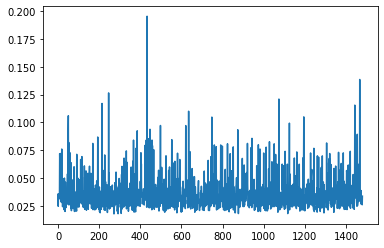

In [66]:
plt.plot(loss_test)

In [67]:
# Detect all the samples which are anomalies.
anomalies = loss_test > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

Number of anomaly samples:  114
Indices of anomaly samples:  (array([   8,   10,   14,   18,   49,   50,   52,   57,   63,   91,  110,
        116,  128,  153,  169,  193,  214,  227,  246,  311,  321,  328,
        332,  336,  364,  367,  378,  380,  385,  403,  405,  423,  426,
        429,  433,  439,  443,  447,  457,  459,  462,  465,  498,  525,
        553,  558,  568,  581,  592,  621,  635,  637,  641,  730,  743,
        748,  760,  769,  791,  799,  824,  837,  852,  874,  896,  905,
        921,  938,  943,  966,  974,  982, 1000, 1012, 1028, 1040, 1051,
       1058, 1064, 1074, 1090, 1095, 1104, 1115, 1125, 1149, 1161, 1173,
       1191, 1194, 1195, 1228, 1244, 1261, 1267, 1285, 1306, 1316, 1319,
       1321, 1327, 1350, 1364, 1377, 1387, 1411, 1414, 1421, 1443, 1444,
       1449, 1455, 1460, 1467]),)


In [69]:
predicted_anomoloies = anomalies.nonzero()

In [71]:
x_test.shape

(1481, 28, 28)

In [85]:
#np.array(predicted_anomoloies).reshape(-1).tolist() converted to list

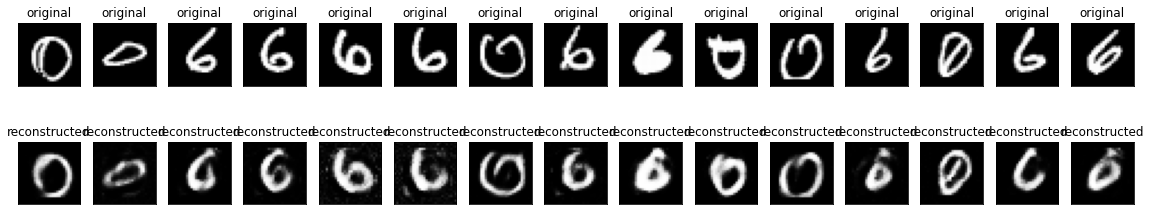

In [86]:
x = np.array(predicted_anomoloies).reshape(-1)[:15]
n = len(x)
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[x[i]].reshape(28,28))
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_test[x[i]].reshape(28,28))
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

Check the accuracy of the anomolies detected.

In [87]:
label_predicted =  np.array(np.where(anomalies))

In [88]:
label_predicted =  label_predicted.reshape(-1)

In [99]:
TP = 0
FP = 0
for i in label_predicted:
  if y_test[i] == 6:
    TP = TP+1
  else:
    FP = FP + 1  
FN = num_anomo - TP

In [90]:
TP

84

In [101]:
FP

30

In [102]:
Precision = (TP)/(TP+FP)
print(Precision)

0.7368421052631579


In [103]:
Recall = (TP)/(TP+FN)
print(Recall)

0.8235294117647058


# SSIM



In [116]:
x_train_new = np.expand_dims(x_train, axis = 3)
decoded_imgs_new = np.expand_dims(decoded_imgs, axis = 3)

In [120]:
SSIM_regular = tf.image.ssim(x_train_new, decoded_imgs_new,max_val=1).numpy()

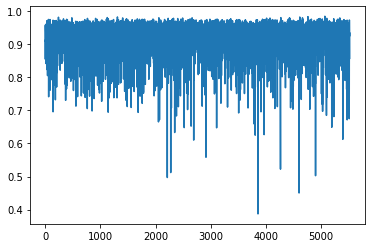

In [121]:
plt.plot(SSIM_regular)

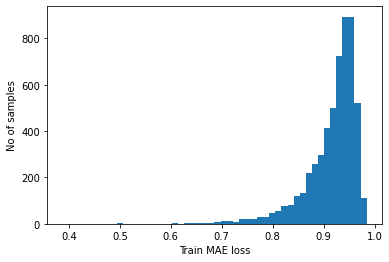

In [123]:
plt.hist(SSIM_regular, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

In [125]:
SSIM_regular.mean()

0.9163324

In [129]:
np.median(SSIM_regular)

0.9312234

In [140]:
np.percentile(SSIM_regular,1)

0.7306457424163818

> SSIM on test data

In [109]:
x_test_new = np.expand_dims(x_test, axis = 3)
decoded_test_new= np.expand_dims(decoded_test, axis = 3)

In [110]:
SSIM = tf.image.ssim(decoded_test_new, x_test_new,max_val=1).numpy()

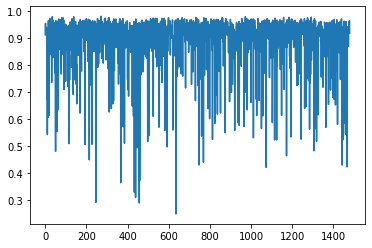

In [113]:
plt.plot(SSIM)

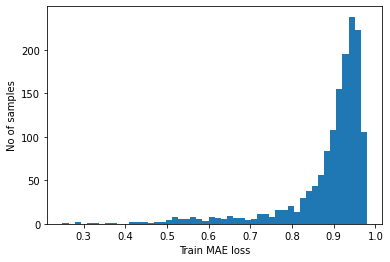

In [115]:
plt.hist(SSIM, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

In [127]:
SSIM.mean()

0.8868595

In [135]:
np.median(SSIM)

0.92363125

In [143]:
SSIM_test = np.percentile(SSIM, 1)

> We can observe that test data has done worse than regular images with only 0 labels on SSIM 

## Assign Anomoly

> Let us assign the threshold as max among worst 1 percentage of total training images.

In [146]:
threshold = np.percentile(SSIM_regular,1)

In [147]:
# Detect all the samples which are anomalies.
anomalies = SSIM < threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

Number of anomaly samples:  122
Indices of anomaly samples:  (array([   8,   10,   14,   18,   49,   50,   52,   57,   58,   63,   91,
        110,  116,  136,  151,  153,  169,  193,  214,  223,  227,  246,
        309,  311,  321,  328,  332,  356,  367,  373,  378,  380,  385,
        403,  405,  423,  428,  429,  433,  439,  443,  447,  457,  459,
        462,  498,  504,  525,  553,  581,  592,  621,  635,  637,  682,
        711,  730,  743,  748,  760,  762,  769,  791,  799,  813,  824,
        828,  837,  852,  874,  896,  905,  910,  921,  938,  943,  966,
        974,  982, 1000, 1012, 1024, 1028, 1040, 1051, 1058, 1074, 1104,
       1115, 1125, 1149, 1161, 1173, 1194, 1195, 1223, 1228, 1244, 1261,
       1267, 1285, 1306, 1316, 1319, 1321, 1327, 1350, 1364, 1377, 1387,
       1398, 1404, 1411, 1421, 1443, 1444, 1448, 1449, 1455, 1460, 1464,
       1467]),)


In [148]:
predicted_anomoloies = anomalies.nonzero()

In [149]:
x_test.shape

(1481, 28, 28)

In [ ]:
#np.array(predicted_anomoloies).reshape(-1).tolist() converted to list

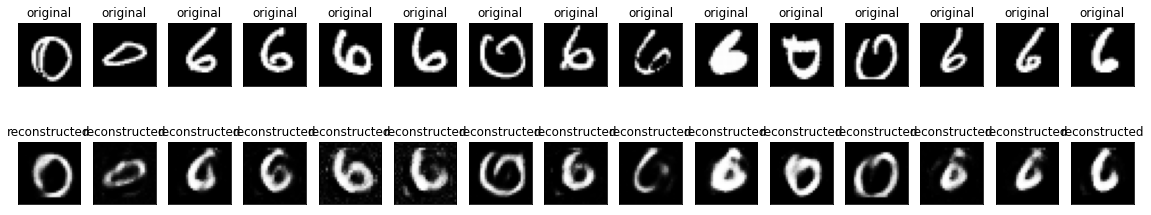

In [150]:
x = np.array(predicted_anomoloies).reshape(-1)[:15]
n = len(x)
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[x[i]].reshape(28,28))
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_test[x[i]].reshape(28,28))
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

Check the accuracy of the anomolies detected.

In [151]:
label_predicted =  np.array(np.where(anomalies))

In [152]:
label_predicted =  label_predicted.reshape(-1)

In [153]:
TP = 0
FP = 0
for i in label_predicted:
  if y_test[i] == 6:
    TP = TP+1
  else:
    FP = FP + 1  
FN = num_anomo - TP

In [154]:
TP

95

In [155]:
FP

27

In [156]:
Precision = (TP)/(TP+FP)
print(Precision)

0.7786885245901639


In [157]:
Recall = (TP)/(TP+FN)
print(Recall)

0.9313725490196079


## Assign Anomoly with stricter threshold

> Let us assign the threshold as max among worst 0.5 percentage of total training images.

In [236]:
threshold = np.percentile(SSIM_regular,0.5)

In [237]:
# Detect all the samples which are anomalies.
anomalies = SSIM < threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

Number of anomaly samples:  102
Indices of anomaly samples:  (array([   8,   10,   14,   18,   50,   52,   57,   58,   63,  116,  136,
        153,  169,  193,  214,  227,  246,  309,  311,  321,  328,  332,
        367,  373,  378,  380,  385,  405,  423,  428,  429,  433,  439,
        443,  447,  457,  459,  498,  504,  525,  553,  581,  592,  621,
        635,  637,  730,  748,  760,  762,  769,  791,  799,  813,  824,
        828,  837,  852,  874,  896,  921,  938,  943,  966,  982, 1000,
       1012, 1024, 1028, 1040, 1051, 1058, 1074, 1104, 1115, 1125, 1149,
       1173, 1194, 1195, 1244, 1261, 1267, 1285, 1306, 1316, 1319, 1321,
       1327, 1364, 1377, 1398, 1404, 1411, 1421, 1443, 1444, 1449, 1455,
       1460, 1464, 1467]),)


In [238]:
predicted_anomoloies = anomalies.nonzero()

In [239]:
x_test.shape

(1481, 28, 28)

In [240]:
#np.array(predicted_anomoloies).reshape(-1).tolist() converted to list

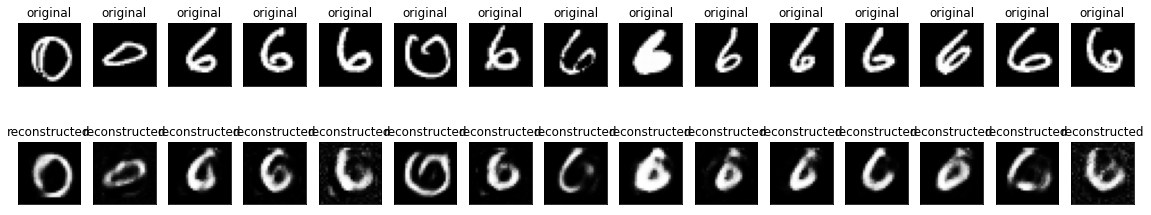

In [241]:
x = np.array(predicted_anomoloies).reshape(-1)[:15]
n = len(x)
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[x[i]].reshape(28,28))
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_test[x[i]].reshape(28,28))
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

Check the accuracy of the anomolies detected.

In [242]:
label_predicted =  np.array(np.where(anomalies))

In [243]:
label_predicted =  label_predicted.reshape(-1)

In [244]:
TP = 0
FP = 0
for i in label_predicted:
  if y_test[i] == 6:
    TP = TP+1
  else:
    FP = FP + 1  
FN = num_anomo - TP

In [245]:
TP

86

In [246]:
FP

16

In [249]:
FN

16

In [247]:
Precision = (TP)/(TP+FP)
print(Precision)

0.8431372549019608


In [248]:
Recall = (TP)/(TP+FN)
print(Recall)

0.8431372549019608


# Conclusion

> The data with just with regular images i.e. shape 0 itself is very noisy, and hence would have a big reconstruction error.

> So, any method contigent upon loss will misclassify some regular images as anomolyies.

> We considered two threshold, one based on absolute error and another on SSIM.



> We can observe that having a stricter threshold decreases the false positives and can be tuned to increase precision if that is more critical.

> We will use convolutional network in the next file.